In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch

### Read in Data

In [68]:
data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
data2011 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2011.csv")
data2012 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2012.csv")
data2013 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2013.csv")
data2014 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2014.csv")
data2015 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2015.csv")
# data2016 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2016.csv")
# data2017 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2017.csv")
# data2018 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2018.csv")
# data2019 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2019.csv")

data = data2009.append(data2010)
data = data.append(data2011)
data = data.append(data2012)
data = data.append(data2013)
data = data.append(data2014)
# data = data.append(data2015)
# data = data.append(data2016)
# data = data.append(data2017)
# data = data.append(data2018)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3032025951.py:1: DtypeWarning: Columns (42,167,168,175,176,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3032025951.py:2: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3032025951.py:3: DtypeWarning: Columns (37,38,39,42,46,47,167,168,169,170,173,174,175,176,177,178,179,180,183,184,185,186,189,190,191,192,193,194,195,196,199,200,204,205,206,225,226,227,228,232,233,23

## Preprocessing and Creating Final Score Outcome Variable

In [69]:
def preprocessing(data):
    # Create a new column called 'final_score' and initialize it with NaN values
    data['home_final_score'] = float('nan')
    data['away_final_score'] = float('nan')

    # Loop through each game in the data
    for game_id in data['game_id'].unique():
        # Get the subset of data for the current game
        game_df = data[data['game_id'] == game_id]

        # Get the final score for the game (which should be the score of the last observation)
        home_final_score = game_df.iloc[-1]['total_home_score']
        away_final_score = game_df.iloc[-1]['total_away_score']

        # Set the 'final_score' column for all rows in this game to be the final score
        data.loc[data['game_id'] == game_id, 'home_final_score'] = home_final_score
        data.loc[data['game_id'] == game_id, 'away_final_score'] = away_final_score
        
    data['home_differential'] = data['home_final_score']-data['away_final_score']
    
    data = data[['game_id','home_team', 'away_team', 'posteam_type', 'yardline_100', 'quarter_seconds_remaining', 
                     'half_seconds_remaining', 'game_seconds_remaining', 'drive', 'down', 'ydstogo', 'no_huddle', 
                     'home_timeouts_remaining', 'away_timeouts_remaining', 'score_differential_post', 
                     'total_home_rush_epa','total_away_rush_epa', 'total_home_pass_epa','total_away_pass_epa',
                     'score_differential_post', 'total_home_score', 'total_away_score', 'home_differential']]

    data = data.dropna()
    
    data['home_team'] = data['home_team'].astype(str)
    data['away_team'] = data['away_team'].astype(str)
    data['posteam_type'] = data['posteam_type'].astype(str)
    
    df = data

    categorical_vars = ['home_team', 'away_team', 'posteam_type', 'no_huddle']
    numerical_vars = ['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining',
                  'drive', 'down', 'ydstogo', 'home_timeouts_remaining', 'away_timeouts_remaining',
                  'score_differential_post', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa',
                  'total_away_pass_epa', 'total_home_score', 'total_away_score']

    # One-hot encode the categorical variables
    ohe = OneHotEncoder(sparse=False)
    categorical_data = ohe.fit_transform(df[categorical_vars])

    # Standardize the numerical variables
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(df[numerical_vars])

    # Combine the categorical and numerical data into a single array
    X = np.concatenate((categorical_data, numerical_data), axis=1)
    X = np.asarray(X).astype('float32')

    # Split the data into training and testing sets
    y = df['home_differential']
    return X, y

### Create Subset of halftime plays

In [70]:
testing = data2015
half_time = testing[(testing['game_seconds_remaining'] > 1800) & (testing['game_seconds_remaining'] < 1820)]
training = data

### Create Training and testing data

In [71]:
X_test_half, y_test_half = preprocessing(half_time)
X_test_full, y_test_full = preprocessing(testing)
X_train, y_train = preprocessing(training)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3344466308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['home_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3344466308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['away_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_4616\3344466308.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Reshape Data for neural network

In [72]:
n_time_steps = 1
n_features = X_train.shape[1]
X_train = X_train.reshape((X_train.shape[0], 1,  X_train.shape[1]))
X_test_full = X_test_full.reshape((X_test_full.shape[0], 1, X_test_full.shape[1]))
X_test_half = X_test_half.reshape((X_test_half.shape[0], 1, X_test_half.shape[1]))

### Define Network Architecture

In [73]:
from torch import nn

class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Start by flattening each 28x28 image to 784 features
        self.flatten = nn.Flatten()
        
        ## Apply the following layers sequentially
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(85, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    ## Function to generate predictions
    def forward(self, x):
        
        ## First it flattens x (note the capitalization, this is flatten() as defined above)
        x = self.flatten(x)
        
        ## Then it applies "linear_relu_stack()" (defined above)
        scores = self.linear_relu_stack(x)
        
        return scores

In [74]:
import torch
import torchvision

## Hyperparms
epochs = 50
lrate = 0.001
bsize = 72

## Cost Function (MSE Loss)
cost_fn = nn.MSELoss()

## Initialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

In [75]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

y_tensor = torch.from_numpy(y_train.values)

data_tensor = torch.from_numpy(X_train)

train_loader = DataLoader(TensorDataset(data_tensor.type(torch.FloatTensor), y_tensor.type(torch.FloatTensor)), batch_size=bsize)

### Train Network

In [76]:
import numpy as np

## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(outputs, labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    # print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates

C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


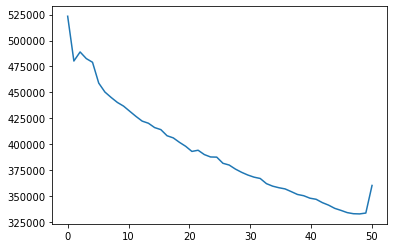

In [77]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [78]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

y_tensor_test_full = torch.from_numpy(y_test_full.values)
y_tensor_test_half = torch.from_numpy(y_test_half.values)

data_tensor_test_full = torch.from_numpy(X_test_full)
data_tensor_test_half = torch.from_numpy(X_test_half)

test_loader_half = DataLoader(TensorDataset(data_tensor_test_half.type(torch.FloatTensor), y_tensor_test_half.type(torch.FloatTensor)), batch_size=bsize)
test_loader_full = DataLoader(TensorDataset(data_tensor_test_full.type(torch.FloatTensor), y_tensor_test_full.type(torch.FloatTensor)), batch_size=bsize)

### Test Model

In [79]:
from sklearn.metrics import mean_squared_error
outputs_half = np.array([])    
total_cost = 0.0
num_batches = len(test_loader_half)
for i, data in enumerate(test_loader_half,0):
    inputs_half, labels = data
    curOutputs = net(inputs_half)
    outputs_half = np.append(outputs_half, curOutputs.detach().numpy())
    cost = cost_fn(curOutputs, labels)
    total_cost += cost.item()

mse = total_cost / num_batches
print(mse)

root_mse = np.sqrt(mse)
print(root_mse)

263.27601841517856
16.22578252088874


C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([70])) that is different to the input size (torch.Size([70, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


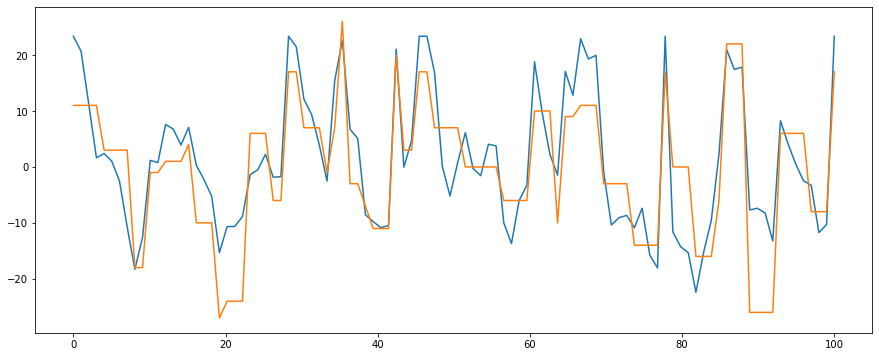

In [88]:
import matplotlib.pyplot as plt

## Plot predicted values against true values
x = np.linspace(0,100,100)
plt.figure(figsize=(15,6))
plt.plot(x, outputs_half[0:100], label = "Predicted")
plt.plot(x, y_test_half[0:100], label = "True")
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
outputs_full = np.array([])    
total_cost = 0.0
num_batches = len(test_loader_full)
for i, data in enumerate(test_loader_full,0):
    inputs_full, labels = data
    curOutputs = net(inputs_full)
    outputs_full = np.append(outputs_full, curOutputs.detach().numpy())
    cost = cost_fn(curOutputs, labels)
    total_cost += cost.item()

mse = total_cost / num_batches
print(mse)

root_mse = np.sqrt(mse)
print(root_mse)

C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


169.29558517399644
13.011363693863778


C:\Users\Laptop\Anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([65, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Predictions Plots

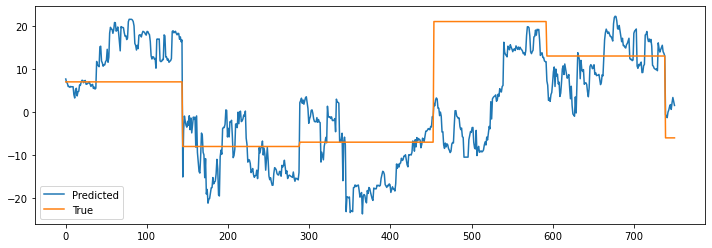

In [94]:
x = np.linspace(0,750,750)
plt.figure(figsize=(12,4))
plt.plot(x, outputs_full[0:750], label = "Predicted")
plt.plot(x, y_test_full[0:750], label = "True")
plt.legend()
plt.show()

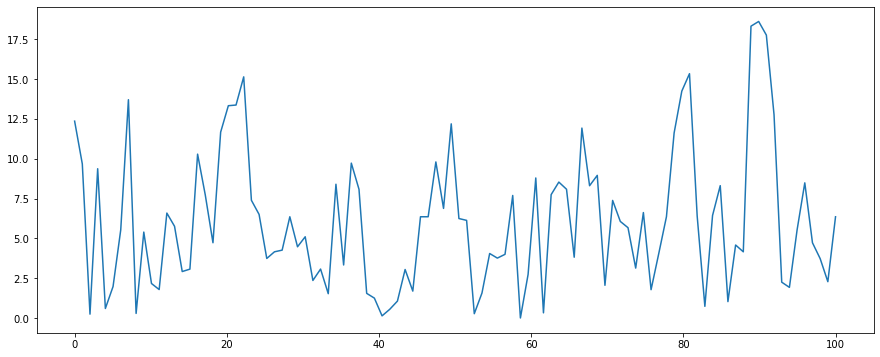

In [89]:
plt.figure(figsize=(12,4))
x = np.linspace(0,100,100)
plt.plot(x, np.abs(outputs_half[0:100]-y_test_half[0:100]), label = "Predicted")
#plt.plot(x, y_test_half[0:100], label = "True")
plt.show()

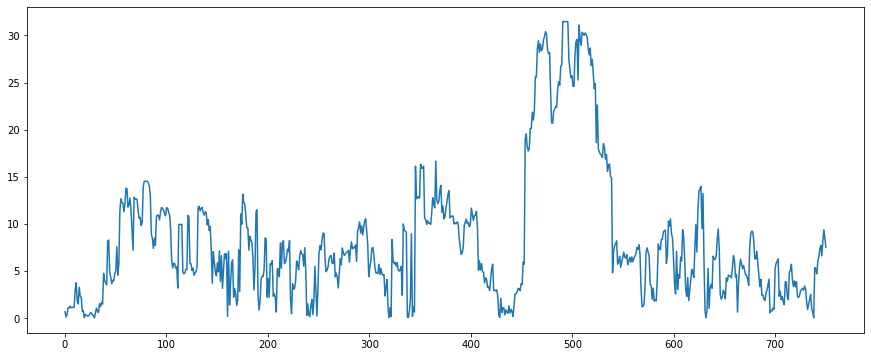

In [92]:
plt.figure(figsize=(12,4))
x = np.linspace(0,750,750)
plt.plot(x, np.abs(outputs_full[0:750]-y_test_full[0:750]), label = "Predicted")
#plt.plot(x, y_test_half[0:100], label = "True")
plt.show()